In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline


In [2]:
from transformers import (
    GPT2Config,
    GPT2Tokenizer,
    GPT2LMHeadModel,
)


/home/cgagne/cvar_generation/conda_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
modelname = '../models/pretrained/gpt2-large/'
config = GPT2Config.from_pretrained(modelname)
tokenizer = GPT2Tokenizer.from_pretrained(modelname)

In [4]:
import sys
sys.path.append('../')
from rl_learner import TD_Learner
import torch
import pickle
device = 'cpu'

from cvar_helpers import calc_cvar_from_samples


### Load Training Data

In [5]:
file = '../data/results/single_sentences_IYou_3/full_generations.txt'
f = open(file, "r")
sentences = f.readlines()
sentences = np.array([s.replace('\n','') for s in sentences])
rewards =  np.array([float(s.split('r=')[-1]) for s in sentences])
print(len(sentences))

73566


### Load Logs and Quantile Learner

In [6]:
epoch=95
hidden_dim =101
n_quantiles = 10
prompt_enc = ''
filename=f'../data/results/single_sentences_IYou_3/'
filename+=f'quantile_learner_{hidden_dim}_0.1{prompt_enc}/log_quantile_learner_epoch{epoch}.pkl'

Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)
Z_network.load_state_dict(torch.load(filename.replace('log_',''),map_location=torch.device('cpu')))

log = pickle.load(open(filename,'rb'))
loss = np.array(log['loss'])
epoch = np.array(log['epoch'])

### Training Loss

Text(0.5, 0, 'epochs')

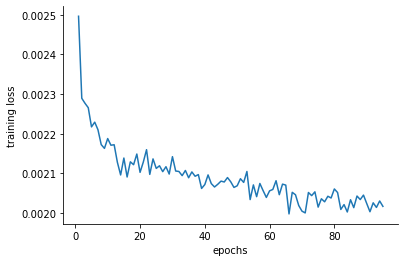

In [7]:
plt.plot(epoch, loss)
sns.despine()
plt.ylabel('training loss')
plt.xlabel('epochs')

### Stored Examples

In [8]:
examples = ['I woke up. I ate breakfast.',
            'I woke up. I ate breakfast. And',
            'I woke up. I ate breakfast. And I had the',
            'I woke up. I ate breakfast. And I had the most horrible',
            'I woke up. I ate breakfast. And I was really']

In [9]:
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
taus

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [10]:
for example in examples:

    plt.figure()
    plt.plot(epoch, np.array(log[example]))
    sns.despine()
    plt.axhline(y=-1, color='k', linestyle='--')
    plt.axhline(y=1, color='k', linestyle='--')
    plt.ylabel('sentiment value')
    plt.xlabel('epochs')
    plt.title(example)

    #sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
    #thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
    #print(thetas)
    #for theta in thetas:
    #        plt.axhline(y=theta, linestyle='--', color='k', linewidth=0.5)

KeyError: 'I woke up. I ate breakfast.'

<Figure size 432x288 with 0 Axes>

### Examples from Training Set

In [11]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

In [17]:
example = 'I need to study hard. I need surgery. I made dinner.'
example = 'I hate'

inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()
print(theta_hats_last)

#sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
#thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
#print(np.round(thetas,2))

[-1.15 -1.05 -0.97 -0.91 -0.85 -0.79 -0.73 -0.67 -0.58 -0.41]


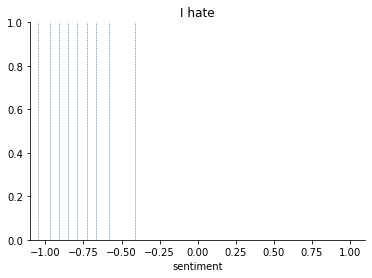

In [19]:
plt.figure()
axes = plt.gca()

inputs = tokenizer(example, return_tensors='pt').to(device)
with torch.no_grad():
    output = model(input_ids=inputs['input_ids'],
                   attention_mask=inputs['attention_mask'],
                   output_hidden_states=True)
    states = output['hidden_states'][-1]
    theta_hats = Z_network(states).detach().cpu().numpy().round(2)
    theta_hats_last = theta_hats[:,-1,:].squeeze()

for theta in theta_hats_last:
    plt.axvline(x=theta, linestyle='--', linewidth=0.5)

# empirical quantiles
# sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
# thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
# for theta in thetas:
#     plt.axvline(x=theta, ymax=0.5, linestyle='--', linewidth=0.5, color='k')

plt.title(example)
plt.xlabel('sentiment')
plt.xlim([-1.1,1.1])
sns.despine()

### Examples

In [20]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

[-0.2  -0.16 -0.13 -0.1  -0.08 -0.06 -0.04 -0.03 -0.03  0.  ]
[-0.06 -0.05 -0.03 -0.01 -0.01  0.    0.01  0.01  0.01  0.03]
[-0.65 -0.54 -0.46 -0.39 -0.34 -0.28 -0.23 -0.17 -0.1   0.07]
[-1.02 -0.99 -0.96 -0.93 -0.91 -0.89 -0.86 -0.84 -0.82 -0.72]
[-1.   -0.88 -0.79 -0.72 -0.65 -0.59 -0.51 -0.42 -0.3  -0.04]
[-1.17 -1.15 -1.12 -1.08 -1.06 -1.04 -1.01 -0.98 -0.95 -0.83]
[-0.9  -0.77 -0.67 -0.58 -0.51 -0.44 -0.36 -0.28 -0.16  0.07]
[-0.5  -0.32 -0.21 -0.11 -0.03  0.05  0.13  0.23  0.34  0.57]
[-0.6  -0.41 -0.28 -0.18 -0.08  0.02  0.13  0.26  0.43  0.75]
[-0.4  -0.24 -0.14 -0.05  0.02  0.09  0.16  0.24  0.34  0.55]
[-0.64 -0.46 -0.34 -0.24 -0.16 -0.08 -0.    0.09  0.2   0.44]
[-0.35 -0.33 -0.31 -0.29 -0.28 -0.27 -0.26 -0.25 -0.25 -0.22]
[-0.54 -0.41 -0.33 -0.27 -0.22 -0.17 -0.13 -0.07 -0.01  0.13]
[-0.99 -0.94 -0.91 -0.87 -0.84 -0.81 -0.79 -0.76 -0.74 -0.66]
[0.23 0.31 0.36 0.4  0.44 0.47 0.5  0.52 0.55 0.65]
[0.17 0.23 0.26 0.3  0.33 0.35 0.37 0.39 0.41 0.47]
[-1.13 -1.02 -0.93 -0.85 -0.

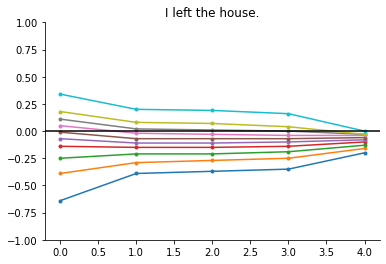

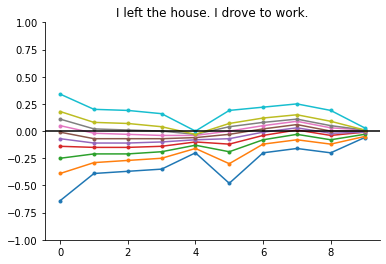

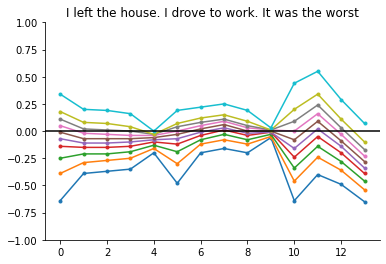

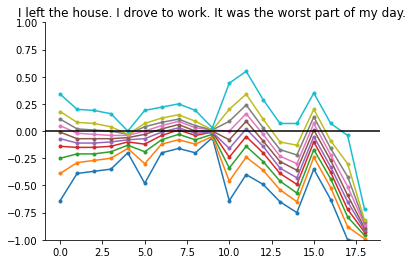

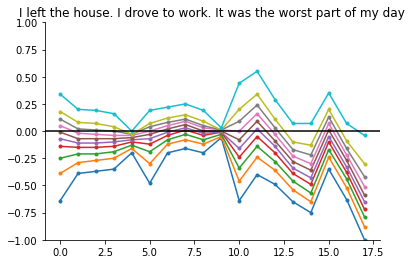

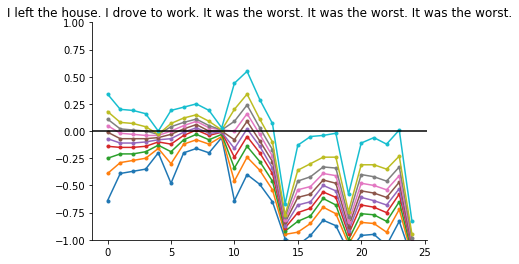

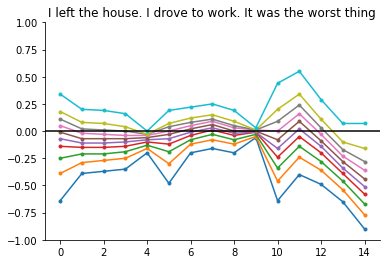

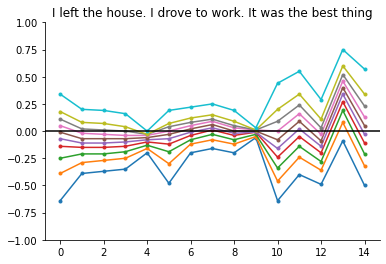

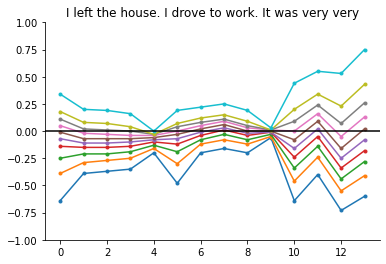

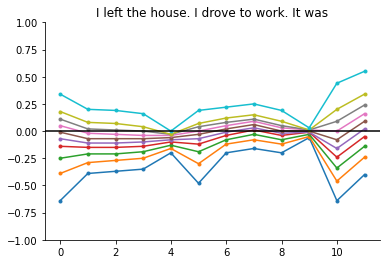

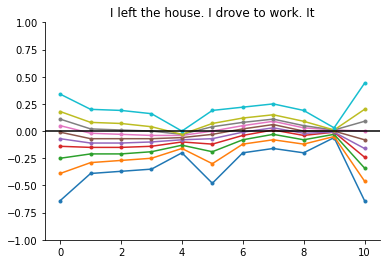

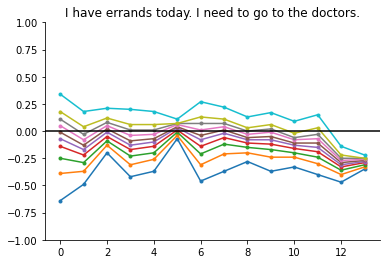

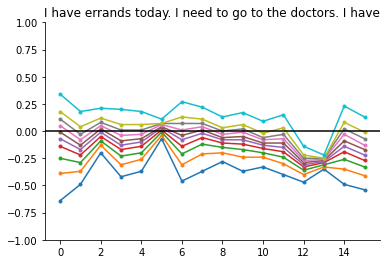

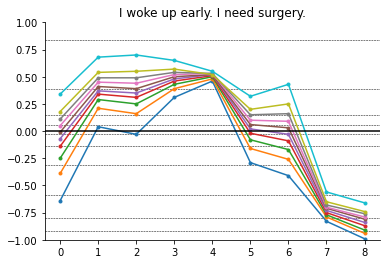

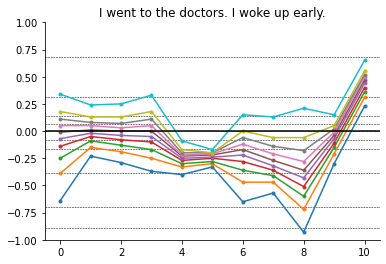

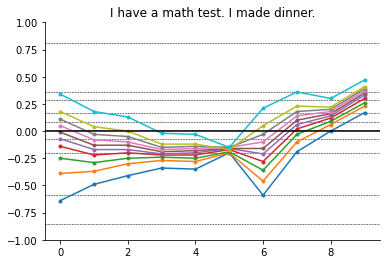

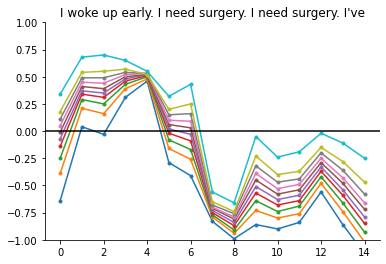

In [39]:
examples = ['I left the house.',
            'I left the house. I drove to work.',
            'I left the house. I drove to work. It was the worst',
            'I left the house. I drove to work. It was the worst part of my day.',
            'I left the house. I drove to work. It was the worst part of my day',
            'I left the house. I drove to work. It was the worst. It was the worst. It was the worst.',
            'I left the house. I drove to work. It was the worst thing',
            'I left the house. I drove to work. It was the best thing',
            'I left the house. I drove to work. It was very very',
            'I left the house. I drove to work. It was',
            'I left the house. I drove to work. It',
            'I have errands today. I need to go to the doctors.',
            'I have errands today. I need to go to the doctors. I have',
           'I woke up early. I need surgery.',
            'I went to the doctors. I woke up early.',
            'I have a math test. I made dinner.',
            "I woke up early. I need surgery. I need surgery. I've"]
for example in examples:
    inputs = tokenizer(example, return_tensors='pt').to(device)
    with torch.no_grad():
        output = model(input_ids=inputs['input_ids'],
                       attention_mask=inputs['attention_mask'],
                       output_hidden_states=True)
        states = output['hidden_states'][-1]
        theta_hats = Z_network(states).detach().cpu().numpy().round(2)
        theta_hats_last = theta_hats[:,-1,:].squeeze()
    print(theta_hats_last)

    plt.figure()
    
    sel = np.array([s.startswith(example) for s in sentences]).astype('bool')
    if np.sum(sel)>10:
        thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
        for theta in thetas:
            plt.axhline(y=theta, linestyle='--', linewidth=0.5, color='k')
    
    plt.title(example)
    plt.plot(theta_hats.squeeze(),marker='.');
    plt.ylim([-1,1])
    plt.axhline(y=0., color='k')
    sns.despine()

### Plotting Distributions

In [24]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05]
top_k =10
prompt_enc = ''
for alpha in alphas:

    file = f'../data/results/single_sentences_IYou_3/ends_cvar_{alpha}_{top_k}{prompt_enc}_unres.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        try:
            r = float(s.split('r=')[-1])
            rewards_cvar[alpha].append(r)
        except:
            rewards_cvar[alpha].append(np.nan)
    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


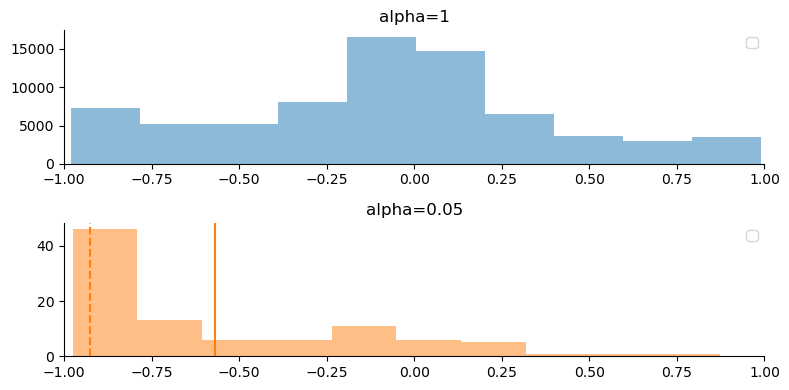

In [25]:
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')

fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(rewards[sel], alpha=0.5, label=f'{stem}', density=False)

plt.legend()
sns.despine()
plt.xlim([-1,1])
plt.title(f'alpha=1')

for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    
    
    _, cvar = calc_cvar_from_samples(rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-1,1])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

### Loading GPT-2

In [26]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

### Printing Code

In [27]:
def colored(r, g, b, text):
    return "\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r, g, b, text)
  
    
def create_strings(t, p, pd, diff, tokens, selected_tokens):
    probs_str = colored(0, 0, 0, 'p=\t')
    dis_probs_str = colored(0, 0, 0, 'pd=\t')
    tokens_str = 't=\t'
    
    for pi, pdi, di, tok in zip(p[t,:], pd[t,:], diff[t,:], tokens[t,:]):
        pis=str(np.round(pi,2))
        pis = colored(0, 0, 0, pis)
        probs_str+=pis
        probs_str+='\t'

        pis=str(np.round(pdi,2))
        if di<-0.05:
            pis = colored(200, 0, 0, pis)
        elif di<-0.025:
            pis = colored(100, 0, 0, pis)
        elif di>0.05:
            pis = colored(0, 200, 0, pis)
        elif di>0.025:
            pis = colored(0, 100, 0, pis)
        else:
            pis = colored(0, 0, 0, pis)
        dis_probs_str+=pis
        dis_probs_str+='\t'
        
        tok = tok.replace('\n','/n')
        if tok.strip()==selected_tokens[t]:
            tok = colored(0, 0, 200, tok)
        else:
            tok = colored(0, 0, 0, tok)
        tokens_str += tok
        tokens_str += '\t'

    #if t==0:
    #    import ipdb; ipdb.set_trace()

    return(probs_str, dis_probs_str, tokens_str)

def create_cvar_strings(t, cvars, sel_alphas=[0,0.05,0.25,0.55,0.75,1.]):
    cvar_str = ''
    for alpha in sel_alphas:
        cvar_str+=str(alpha)+'\t'
        c = cvars[t,:,alpha_set.index(alpha)]
        for ci in c:
            cvar_str+=str(np.round(ci,2))
            cvar_str+='\t'
        cvar_str+='\n'
    return(cvar_str)

def create_quantile_strings(t, quantiles, sel_taus=[0.05,0.25,0.55,0.75,0.95]):
    q_str = ''
    for tau in sel_taus:
        q_str+=str(tau)+'\t'
        c = quantiles[t,:,taus_set.index(tau)]
        for ci in c:
            q_str+=str(np.round(ci,2))
            q_str+='\t'
        q_str+='\n'
    return(q_str)

def print_example(i, alpha=0.05):
    
    sentence = sentences_storage[alpha][i]
    selected_tokens = [t.replace('Ġ','') for i,t in enumerate(tokenizer.tokenize(sentence))]
    alphas_per_seq = alpha_storage[alpha][i]
    prompt = prompt_storage[alpha][i]
    n_tokens = len(selected_tokens)
    pd = np.array(pd_storage[alpha][i])
    p = np.array(p_storage[alpha][i])
    tokens = np.array(token_storage[alpha][i])
    diff = pd-p
    cvars = np.array(cvar_storage[alpha][i])
    quantiles = np.array(quantile_storage[alpha][i])
    successes = success_storage[alpha][i]

    #assert p.shape[0]==n_tokens

    print(f'prompt: {prompt}')
    print(f'{sentence}')
    print()
    partial_sentence = ''
    for t, tok in enumerate(selected_tokens):

        probs_str, dis_probs_str, tokens_str = create_strings(t, p, pd, diff, tokens, selected_tokens)

        cvar_str = create_cvar_strings(t, cvars, sel_alphas=[0,0.05,0.25,0.55,0.75,1.])
        cvar_str = colored(0,0,0,cvar_str)

        q_str = create_quantile_strings(t, quantiles, sel_taus=[0.05,0.25,0.55,0.75,0.95])
        if successes[t]:
            q_str = colored(0,0,0,q_str)
        else:
            q_str = colored(255,0,0,q_str)

        print(colored(0, 0, 0, '--------'))
        print(colored(0, 0, 0, f'({str(np.round(alphas_per_seq[t],2))}) '+partial_sentence))
        print(colored(0, 0, 0, '--------'))
        print(tokens_str)
        print(probs_str)
        print(dis_probs_str)
        print()
        print(q_str)
        print()
        print(cvar_str)
        print()

        partial_sentence+=tok+' '

### Printing Examples

In [28]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [34]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
sentences_storage_full = {}
rewards_storage = {}
token_storage = {}
cvar_storage = {}
prompt_storage = {}
quantile_storage = {}
success_storage = {}
top_k=10
prompt_enc=''

for alpha in [0.05]:#, 0.2, 0.5, 0.75]:

    file = f'../data/results/single_sentences_IYou_3/cvar_output_{alpha}_{top_k}{prompt_enc}_unres.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alphas']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences']
    sentences_storage_full[alpha] = loaded['sentences_full']
    rewards_storage[alpha] = loaded['rewards']
    token_storage[alpha] = loaded['token_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']
    prompt_storage[alpha]= loaded['prompt_storage']
    success_storage[alpha] = loaded['successes']

In [35]:
bad_words = ["\n", "\r", '"',' "','."',' (']
bad_words_ids = [tokenizer.encode(bad_word, add_prefix_space=False) for bad_word in bad_words]
bad_words_ids

[[198], [201], [1], [366], [526], [357]]

In [36]:
tokenizer.decode([220, 198])

' \n'

In [37]:
sentences
for s, (sentence,r) in enumerate(zip(sentences_storage[0.05], rewards_storage[0.05])):
    if sentence not in sentences:
        print(s, sentence, np.round(r,2))

0 I had some lunch and then I was at the doctor's office with a headache. -0.49
1 I'm not going to fail this test. -0.46
2 I had a glass of water. 0.16
3 I'm just not well enough. -0.95
4 It's a horrible, horrible thing, to have a bad tooth. -0.98
5 My mom is getting sick. -0.95
6 [EXCLUDED] nan
7 I need an abortion. -0.76
8 I might fail the test. -0.91
9 I was diagnosed with anxiety and depression. -0.87
10 [EXCLUDED] nan
11 It's a long story… I have a very good doctor. 0.87
12 I'm not a big eater. -0.22
13 It's a little late. -0.53
14 [EXCLUDED] nan
15 I did it all, even though I knew it was a mistake. -0.09
16 [EXCLUDED] nan
17 I can't take care of myself any longer. -0.94
18 What do I do? I can't be a failure as my mom would be. -0.78
19 I don't think I can do it anymore. -0.93
20 I might fail the test. -0.91
21 I even had the time to do my own shopping and go to the store. 0.32
22 I didn't sleep at all and I was so scared. -0.91
23 I was in the bathroom when I fell and broke my wr

### Good examples

In [38]:
print_example(0, alpha=0.05)

prompt: I might fail the test. I went to the grocery store. I walked my dog to the park.
I had some lunch and then I was at the doctor's office with a headache.

-------- 
(0.05)  
-------- 
t=	 I 	 And 	 But 	 It 	 My 	 The 	 Then 	 There 	 When 	 All 	
p=	 0.84 	0.05 	0.02 	0.02 	0.02 	0.02 	0.01 	0.01 	0.01 	0.01 	
pd=	 0.83 	0.0 	0.03 	0.02 	0.08 	0.02 	0.0 	0.02 	0.0 	0.0 	

0.05	-0.64	-0.48	-0.64	-0.64	-0.86	-0.57	-0.42	-0.61	-0.41	-0.37	
0.25	-0.25	-0.25	-0.39	-0.31	-0.49	-0.32	-0.22	-0.38	-0.22	-0.17	
0.55	-0.01	-0.07	-0.18	-0.03	-0.23	-0.13	-0.08	-0.19	-0.08	-0.0	
0.75	0.11	0.04	-0.04	0.16	-0.08	-0.0	0.01	-0.08	0.0	0.11	
0.95	0.34	0.27	0.21	0.55	0.25	0.25	0.21	0.14	0.19	0.34	
 

0	-0.64	-0.48	-0.64	-0.64	-0.86	-0.57	-0.42	-0.61	-0.41	-0.37	
0.05	-0.64	-0.48	-0.64	-0.64	-0.86	-0.57	-0.42	-0.61	-0.41	-0.37	
0.25	-0.38	-0.33	-0.48	-0.43	-0.62	-0.41	-0.29	-0.46	-0.29	-0.24	
0.55	-0.22	-0.22	-0.35	-0.26	-0.45	-0.29	-0.2	-0.34	-0.2	-0.14	
0.75	-0.14	-0.16	-0.28	-0.16	-0.36	-0.22	-0.

### Bad examples

In [78]:
print_example(68, alpha=0.05)

prompt: I made dinner. I might fail the test. I went to the doctors.
I didn't fail that day.

-------- 
(0.05)  
-------- 
t=	 I 	 They 	 The 	 And 	 My 	 It 	 He 	 There 	 But 	 Nothing 	
p=	 0.6 	0.23 	0.05 	0.03 	0.02 	0.02 	0.01 	0.01 	0.01 	0.01 	
pd=	 0.6 	0.04 	0.0 	0.0 	0.04 	0.05 	0.05 	0.15 	0.05 	0.01 	

0.05	-0.61	-0.54	-0.55	-0.53	-0.7	-0.64	-0.59	-0.53	-0.53	-0.64	
0.25	-0.28	-0.33	-0.31	-0.3	-0.37	-0.36	-0.34	-0.35	-0.3	-0.47	
0.55	-0.11	-0.19	-0.15	-0.14	-0.15	-0.11	-0.16	-0.21	-0.13	-0.35	
0.75	-0.01	-0.09	-0.05	-0.03	-0.0	0.08	-0.04	-0.11	-0.01	-0.26	
0.95	0.17	0.1	0.16	0.21	0.29	0.46	0.22	0.1	0.23	-0.1	
 

0	-0.61	-0.54	-0.55	-0.53	-0.7	-0.64	-0.59	-0.53	-0.53	-0.64	
0.05	-0.61	-0.54	-0.55	-0.53	-0.7	-0.64	-0.59	-0.53	-0.53	-0.64	
0.25	-0.38	-0.4	-0.39	-0.38	-0.49	-0.46	-0.42	-0.41	-0.38	-0.53	
0.55	-0.26	-0.31	-0.29	-0.28	-0.34	-0.31	-0.31	-0.32	-0.27	-0.45	
0.75	-0.2	-0.26	-0.23	-0.22	-0.26	-0.22	-0.25	-0.27	-0.21	-0.41	
1.0	-0.16	-0.21	-0.18	-0.16	-0.19	-0.13	-0.1

In [80]:
p_storage[alpha][68][4]

[0.598319,
 0.25391942,
 0.05596433,
 0.03617404,
 0.0118677365,
 0.011138994,
 0.010051746,
 0.009965228,
 0.006628591,
 0.005970897]

In [81]:
token_storage[alpha][68][4]

[' the', '.', ',', ' it', ' my', ' because', ' them', ' any', ' that', ' a']

In [82]:
pd_storage[alpha][68][4]

[0.613537327327959,
 0.08459984692209847,
 0.012748927881095959,
 0.027826345329865963,
 0.07902346168468162,
 0.04127097428163045,
 0.06034014108035234,
 0.040323348856462424,
 0.029800589992993547,
 0.01052903273596249]